<a href="https://colab.research.google.com/github/musella/twitter_crawl/blob/master/notebooks/train_rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [0]:
data_folder = '/gdrive/My Drive/data/twitter_crawl/data'

In [0]:
sequences = pd.read_hdf(data_folder+"/preproc/sequences.hd5")

In [0]:
max_len = sequences["sequences"].apply(len).max()

In [6]:
print(max_len)

35


In [0]:
padded = pad_sequences(sequences["sequences"])

In [0]:
# targets = to_categorical(padded)

from sklearn.preprocessing import OneHotEncoder

class Generate:

    def __init__(self,padded,max_words,batch_size=32):
        self._padded = padded
        self._batch_size = batch_size
        self._nbatches = padded.shape[0] // batch_size
        self._remind = padded.shape[0] % batch_size
        self.nbatches = self._nbatches + 1 if self._remind > 0 else 0

        self._max_words = max_words
        
        
    def __call__(self):
        index = np.arange(self._padded.shape[0])
        while True:
            np.random.shuffle(index)            
            def xy(batch):
                return batch[:,:-1], to_categorical(batch[:,1:],self._max_words)
            for ibatch in range(self._nbatches):
                bindex = index[ibatch*self._batch_size:(ibatch+1)*self._batch_size]
                batch = self._padded[bindex]
                yield xy(batch)
            if self._remind > 0:
                batch =padded[index[-self._remind:]]
                yield xy(batch)
    


In [0]:
# generate._encode.transform(padded[0,1])

In [10]:
padded.shape

(48066, 35)

In [0]:
from keras.layers import Embedding, Input, Concatenate, GRU, Dense, Activation

In [0]:
words_embed_mtx = np.load(data_folder+'/models/sequences/embed_mtx.npy')
hash_embed_mtx = np.load(data_folder+'/models/sequences/hash_mtx.npy')
stop_mtx = np.load(data_folder+'/models/sequences/hash_mtx.npy')


In [0]:
import json

In [14]:
with open(data_folder+"/models/sequences/info.json","r") as fin:
    info = json.loads(fin.read())

print(info)

{'max_words': 1600, 'unk_idx': [902, 1171, 623, 1065, 1274, 1329, 1284, 254, 1339, 1527, 583, 1020, 1097, 1239, 492, 1285, 888, 1133, 1227, 265, 174, 1357, 970, 1543, 620, 700, 1398, 1013, 1438, 1582, 1041, 1233, 1512, 1322, 575, 325]}


In [0]:
import pickle

with open(data_folder+"/models/sequences/tokenizer.pkl","rb") as fin:
    tk = pickle.loads(fin.read())

In [0]:
words_embed_layer = Embedding(words_embed_mtx.shape[0],words_embed_mtx.shape[1],
                              weights=[words_embed_mtx],
                              input_length=max_len-1,mask_zero=True)
hash_embed_layer = Embedding(hash_embed_mtx.shape[0],hash_embed_mtx.shape[1],
                             weights=[hash_embed_mtx],
                             input_length=max_len-1,mask_zero=True)
stop_layer = Embedding(stop_mtx.shape[0],stop_mtx.shape[1],
                       weights=[stop_mtx],
                       input_length=max_len-1,mask_zero=True)


In [0]:
words_embed_layer.trainable = False
hash_embed_layer.trainable = False
stop_layer.trainable = False


In [0]:
from keras.models import Model
from keras.optimizers import Adam

In [0]:
nwords = info["max_words"]+2

inp = Input(padded[:,:-1].shape[1:])
W = words_embed_layer(inp)
H = hash_embed_layer(inp)
S = stop_layer(inp)

concat = Concatenate()([W,H,S])
L = concat

L = GRU(10,return_sequences=True)(L)

L = Dense(nwords)(L)
L = Activation('softmax')(L)
# out = rnn(concat)
out = L
embed_model = Model(inputs=inp,outputs=concat)

model = Model(inputs=inp,outputs=out)
optimzier = Adam(lr=1.e-3)
# ,decay=0.005
model.compile(loss="categorical_crossentropy",optimizer=optimzier)


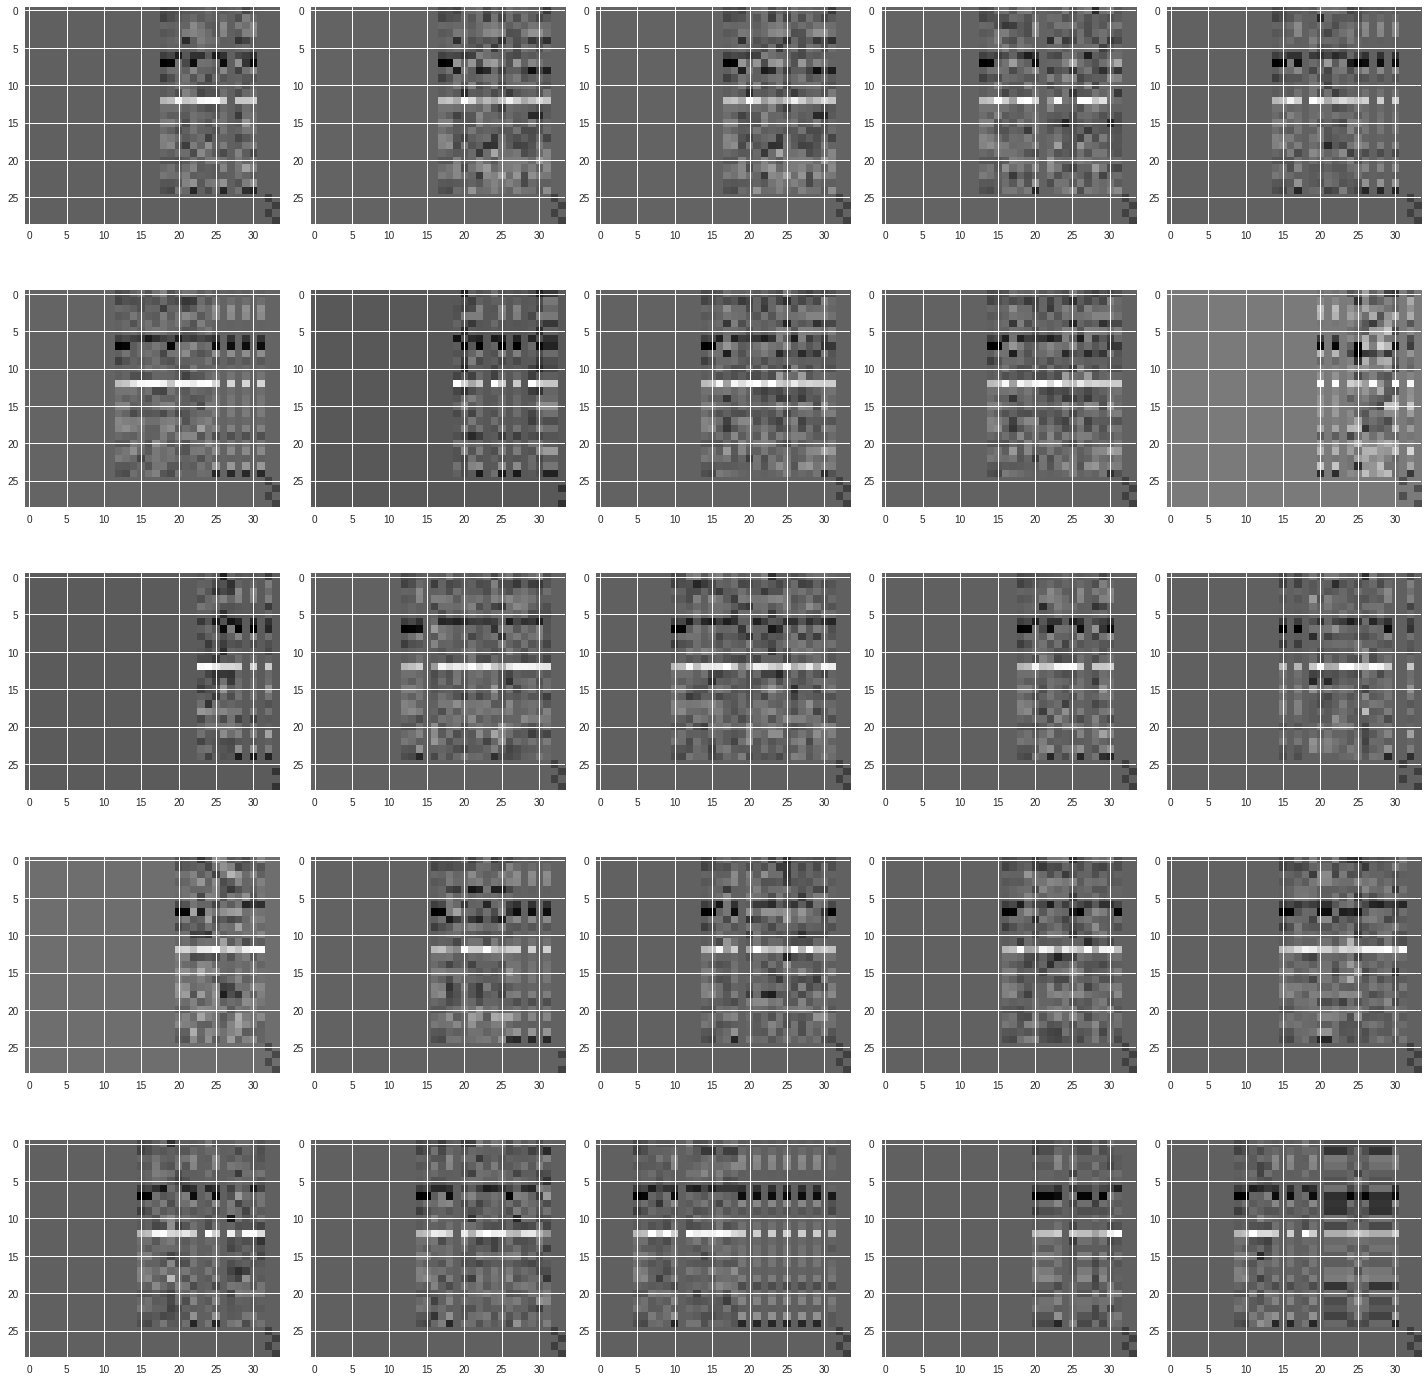

In [20]:
sentences = embed_model.predict(padded[:100,1:])

fig = plt.figure(figsize=(20,20))
for isnt, snt in enumerate( np.random.choice(np.arange(sentences.shape[0]),25) ):
    plt.subplot(5,5,isnt+1)
    plt.imshow(sentences[snt].T)
plt.tight_layout()
plt.savefig("sentences.png")
plt.show()


In [0]:
from keras.callbacks import LambdaCallback

class Sample:
  
  def __init__(self,data,nsamples,model,tokenizer,min_epoch,freq):
    self._data = data
    self._index = np.arange(data.shape[0])
    self._nsamples = nsamples
    self._tokenizer = tokenizer
    self._min_epoch = min_epoch
    self._freq = freq
    self._model = model
    
  def __call__(self,epoch,logs):
    print(epoch)
    if epoch < self._min_epoch: return
    
    if (epoch - self._min_epoch ) % self._freq != 0: return
    
    samples = self._data[np.random.choice(self._index,self._nsamples)]
    mask = (samples[:,1:]!=0)[:,:,np.newaxis]
    predictions = model.predict(samples[:,:-1]).argsort(2)[:,:,-2:]*mask
    # 
    with open("sample_%d.txt" % epoch, "w+") as fout:
      for target,prediction in zip(samples,predictions):
        first_word = (target>0).argmax()
        fout.write(self._tokenizer.sequences_to_texts([target])[0]+'\n')
        fout.write(self._tokenizer.sequences_to_texts([prediction[first_word+1:,-1]])[0]+'\n')
        fout.write(self._tokenizer.sequences_to_texts([prediction[first_word+1:,-2]])[0]+'\n')
        # fout.write(self._tokenizer.sequences_to_texts([prediction[first_word+1:,-3]]))
        fout.write("----\n")
      
    
    
    
     
    
  


In [0]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(padded,test_size=0.2,random_state=12345)

train, valid = train_test_split(train,test_size=0.2,random_state=12345)

generate_train = Generate(train,nwords,batch_size=512)
generate_valid = Generate(valid,nwords,batch_size=512)

gen_train = generate_train()
gen_valid = generate_valid()

# for ii in range(5):
#     X,y = next(gen)
#     print(X.shape,y.shape)

In [0]:
model.fit_generator(gen_train,steps_per_epoch=generate_train.nbatches,epochs=500,
                    validation_data=gen_valid,validation_steps=generate_valid.nbatches,
                    callbacks=[ModelCheckpoint("gru-model.hd5",save_best_only=True),
                               LambdaCallback(on_epoch_end=Sample(test,10,model,tk,30,30)),
                              ])

Epoch 1/500
61/61 [==============================] - 16s 258ms/step - loss: 7.0927 - val_loss: 6.6933
0
Epoch 2/500
61/61 [==============================] - 14s 224ms/step - loss: 6.2569 - val_loss: 5.8708
1
Epoch 3/500
61/61 [==============================] - 14s 222ms/step - loss: 5.6148 - val_loss: 5.4147
2
Epoch 4/500
61/61 [==============================] - 14s 221ms/step - loss: 5.2840 - val_loss: 5.1978
3
Epoch 5/500
61/61 [==============================] - 14s 222ms/step - loss: 5.1395 - val_loss: 5.1129
4
Epoch 6/500
61/61 [==============================] - 14s 223ms/step - loss: 5.0840 - val_loss: 5.0816
5
Epoch 7/500
61/61 [==============================] - 14s 225ms/step - loss: 5.0661 - val_loss: 5.0700
6
Epoch 8/500
61/61 [==============================] - 14s 223ms/step - loss: 5.0557 - val_loss: 5.0644
7
Epoch 9/500
61/61 [==============================] - 14s 223ms/step - loss: 5.0571 - val_loss: 5.0609
8
Epoch 10/500
 7/61 [==>...........................] - ETA: 10s -

In [0]:
sampler = Sample(test,10,model,tk,30,30)

sampler(30,None)

In [0]:
sample = np.random.choice(np.arange(test.shape[0]),5)
sample = test[sample]

predictions = model.predict(sample[:,:-1])



In [0]:
sample.shape

In [0]:
tk.sequences_to_texts(sample)

In [0]:
predicted_words = predictions.argsort(axis=2)[:,:,-1]*(sample[:,1:]!=0)

tk.sequences_to_texts(predicted_words)

In [0]:
tk.word_index